In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# 구글 드라이브 마운트
drive.mount('/content/drive')

# 파일 경로 (드라이브 위치에 따라 수정)
df = pd.read_csv('/content/drive/MyDrive/Dissertation/Dataset/Korea_NewsResult_20230101-20241231.csv', header=1)

print(f"✅ Loaded {len(df)} articles")

Mounted at /content/drive
✅ Loaded 11800 articles


In [ ]:
# 기초 데이터 탐색
print("="*60)
print("DATASET OVERVIEW")
print("="*60)

# 1. 기본 정보
print(f"\n📌 Total articles: {len(df):,}")
print(f"📌 Columns: {df.columns.tolist()}")
print(f"📌 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 2. 결측치 확인
print(f"\n📌 Missing values:")
print(df.isnull().sum())

# 3. 샘플 데이터 확인
print(f"\n📌 Sample data:")
print(df.head(3))

# 4. 각 컬럼 데이터 타입
print(f"\n📌 Data types:")
print(df.dtypes)

DATASET OVERVIEW

📌 Total articles: 11,800
📌 Columns: ['뉴스 식별자', '일자', '언론사', '기고자', '제목', '기관', '키워드', '특성추출(가중치순 상위 50개)', '본문']
📌 Memory usage: 29.61 MB

📌 Missing values:
뉴스 식별자                 0
일자                     0
언론사                    0
기고자                  184
제목                    59
기관                     5
키워드                    0
특성추출(가중치순 상위 50개)      0
본문                     2
dtype: int64

📌 Sample data:
         뉴스 식별자        일자    언론사                     기고자  \
0  2.100101e+06  20230217   매일경제  김명환 기자(teroo@mk.co.kr)   
1  2.100401e+06  20240624  메트로경제                     김연세   
2  2.100851e+06  20230217   아주경제                     전상현   

                                       제목  \
0  김소영 금융위 부위원장 “선진국 규제강화 ESG 금융제도 본격 검토”   
1   기업의 'ESG경영' 수준 가늠한다...환경부, 투자자 안내서 발간   
2    김소영 금융위 부위원장 "ESG 금융제도 정비 창의적 접근 필요"   

                                    기관  \
0  금융위,자본시장연구원,정부,대한상의,ESG,금융감독원,금융위원회   
1                              환경부,ESG   
2  금융위,자본시장연구원,정부,대한상의,

In [ ]:
# 1. 불필요한 컬럼 제거
df = df.drop(columns=['기고자'])

# 2. 컬럼명 영어로 변경 (코딩 편의)
df = df.rename(columns={
    '뉴스 식별자': 'news_id',
    '일자': 'date',
    '언론사': 'outlet',
    '제목': 'title',
    '기관': 'organization',
    '키워드': 'keywords',
    '특성추출(가중치순 상위 50개)': 'extracted_features',
    '본문': 'content'
})

# 3. 결측치 처리
print("🔍 Handling missing values...")

# 먼저 확인
title_missing = df['title'].isnull().sum()
content_missing = df['content'].isnull().sum()

print(f"📌 제목 결측: {title_missing}개")
print(f"📌 본문 결측: {content_missing}개")

# 결측치가 있을 때만 제거
if title_missing > 0 or content_missing > 0:
    original_count = len(df)
    df = df.dropna(subset=['title', 'content']).copy()
    removed = original_count - len(df)
    print(f"✅ {removed}개 기사 제거 완료")
else:
    print("✅ 결측치 없음 - 제거 불필요")

print(f"📌 최종 기사 수: {len(df):,}")

KeyError: "['기고자'] not found in axis"

In [ ]:
# 기관/키워드는 빈 문자열로 대체
df['organization'] = df['organization'].fillna('')
df['keywords'] = df['keywords'].fillna('')
df['extracted_features'] = df['extracted_features'].fillna('')

print(f"✅ After cleaning: {len(df):,} articles")

✅ After cleaning: 11,800 articles


In [ ]:
# Datetime 변환
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# 영국식 표시 (DD/MM/YYYY)
df['date_uk'] = df['date'].dt.strftime('%d/%m/%Y')

# 분석용 컬럼
df['year_month'] = df['date'].dt.to_period('M')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

print(f"✅ 날짜 범위: {df['date_uk'].min()} ~ {df['date_uk'].max()}")
print(f"   예시: {df['date_uk'].iloc[0]}")

✅ 날짜 범위: 01/01/2023 ~ 31/12/2024
   예시: 17/02/2023


In [ ]:
print("\n📌 Step 4: 본문 길이 분석")

df['content_length'] = df['content'].str.len()

print(f"✅ 본문 길이 통계:")
print(f"   평균: {df['content_length'].mean():.0f}자")
print(f"   중간값: {df['content_length'].median():.0f}자")
print(f"   최소: {df['content_length'].min()}자")
print(f"   최대: {df['content_length'].max()}자")


📌 Step 4: 본문 길이 분석
✅ 본문 길이 통계:
   평균: 200자
   중간값: 200자
   최소: 34.0자
   최대: 200.0자


### 분석용 데이터 생성

In [ ]:
# 제목 + 본문 + 키워드 통합
df['analysis_text'] = (
    df['title'].fillna('') + ' ' +
    df['content'].fillna('') + ' ' +
    df['keywords'].fillna('')
)

# 길이 계산
df['analysis_text_length'] = df['analysis_text'].str.len()

print(f"\n✅ 통합 텍스트 생성 완료")
print(f"📌 평균 길이: {df['analysis_text_length'].mean():.0f}자")
print(f"📌 중간값: {df['analysis_text_length'].median():.0f}자")
print(f"📌 최소: {df['analysis_text_length'].min()}자")
print(f"📌 최대: {df['analysis_text_length'].max()}자")

# 샘플 확인
print(f"\n📝 통합 텍스트 샘플 (첫 3개):")
for i in range(3):
    print(f"\n[{i+1}] {df['outlet'].iloc[i]} | {df['date_uk'].iloc[i]}")
    print(f"    {df['analysis_text'].iloc[i][:150]}...")


✅ 통합 텍스트 생성 완료
📌 평균 길이: 939자
📌 중간값: 857자
📌 최소: 279자
📌 최대: 10101자

📝 통합 텍스트 샘플 (첫 3개):

[1] 매일경제 | 17/02/2023
    김소영 금융위 부위원장 “선진국 규제강화 ESG 금융제도 본격 검토” ESG 금융 추진단 1차 회의 
“ESG 잘하는 기업, 제대로 투자받게”

금융위원회가 ESG(환경 사회 지배구조) 금융 추진단을 구성하고 ESG 공시 평가 투자 관련 제도 전반을 정비한다. 금융위는...

[2] 메트로경제 | 24/06/2024
    기업의 'ESG경영' 수준 가늠한다...환경부, 투자자 안내서 발간 /환경부 
 
 기업의 '환경 사회 투명 경영(ESG)' 이행 여부 및 역량 진단을 통해 투자자의 의사 결정을 돕는 '투자금융 ESG 안내서'가 발간됐다. 투자금융이란 기업이 직접적으로 자본을 조달하기...

[3] 아주경제 | 17/02/2023
    김소영 금융위 부위원장 "ESG 금융제도 정비 창의적 접근 필요" 김소영 금융위원회 부위원장 [사진=금융위원회] 
 
김소영 금융위원회 부위원장이 환경 사회적 책무 기업지배구조(ESG) 금융제도 정비를 이뤄나가겠다고 17일 밝혔다. 기후변화 대응에 따른 선진국의 규제 ...



⏳ Step 1: 샘플 500개로 유사도 분포 확인...
⏳ 유사도 계산 중...

✅ 유사도 분석 완료!


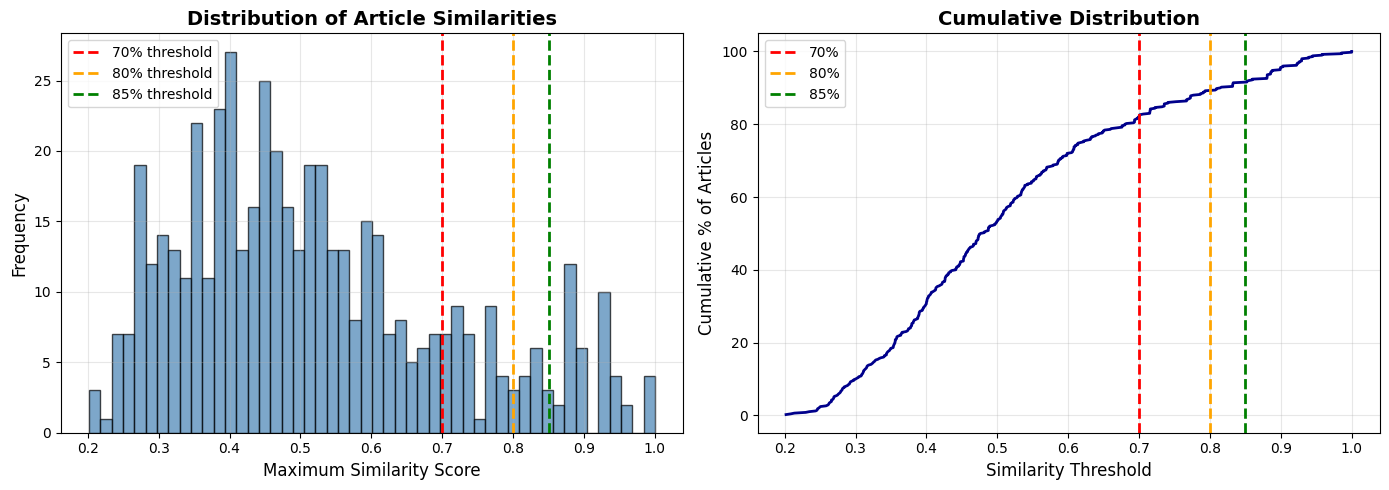


유사도 통계 (샘플 {sample_size}개)
평균 최대 유사도: 0.518
중간값:          0.479
75 percentile:   0.619
90 percentile:   0.815
95 percentile:   0.899

Threshold별 중복 예상 개수
70% 이상:  89개 ( 17.8%) → 전체 예상: ~2,100개
75% 이상:  70개 ( 14.0%) → 전체 예상: ~1,652개
80% 이상:  54개 ( 10.8%) → 전체 예상: ~1,274개
85% 이상:  43개 (  8.6%) → 전체 예상: ~1,014개
90% 이상:  22개 (  4.4%) → 전체 예상: ~519개

고유사도 기사 샘플 (유사도 > 0.8)

[유사도: 0.929]
기사 1: 대한경제 | GC녹십자, 전사 컴플라이언스 관리체계 구축...
기사 2: 한국경제 | GC녹십자, 전사 컴플라이언스 관리체계 구축...

[유사도: 0.903]
기사 1: 파이낸셜뉴스 | 거래소, 한국 자본시장 컨퍼런스 개최...
기사 2: 이투데이 | 한국거래소, 내달 ‘자본시장 콘퍼런스’ 개최 밸류업 지수 연계 ETP 신상품 논의...

[유사도: 0.833]
기사 1: 파이낸셜뉴스 | 중진공-롯데케미칼, 中企 자생력 강화 위해 내일채움공제 '맞손'...
기사 2: 파이낸셜뉴스 | 중진공-롯데알미늄, 상생형 공제로 대 중소 동반성장 이끈다...


In [ ]:
# 1. 샘플로 먼저 테스트 (전체는 시간 오래 걸림)
print("\n⏳ Step 1: 샘플 500개로 유사도 분포 확인...")

sample_size = 500
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

# TF-IDF 벡터화 (제목 + 키워드 사용)
vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),  # 단어 + 2-gram
    min_df=2  # 최소 2번 이상 등장
)

# 제목 + 키워드로 벡터화
sample_texts = (df_sample['title'].fillna('') + ' ' +
                df_sample['keywords'].fillna('')).values

tfidf_matrix = vectorizer.fit_transform(sample_texts)

# 코사인 유사도 계산
print("⏳ 유사도 계산 중...")
similarity_matrix = cosine_similarity(tfidf_matrix)

# 자기 자신 제외 (대각선 = 1.0 제거)
np.fill_diagonal(similarity_matrix, 0)

# 각 기사의 최대 유사도 찾기
max_similarities = similarity_matrix.max(axis=1)

# 분포 시각화
print("\n✅ 유사도 분석 완료!")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
axes[0].hist(max_similarities, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=0.7, color='red', linestyle='--', linewidth=2, label='70% threshold')
axes[0].axvline(x=0.8, color='orange', linestyle='--', linewidth=2, label='80% threshold')
axes[0].axvline(x=0.85, color='green', linestyle='--', linewidth=2, label='85% threshold')
axes[0].set_xlabel('Maximum Similarity Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Article Similarities', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 누적 분포
sorted_sims = np.sort(max_similarities)
cumulative = np.arange(1, len(sorted_sims) + 1) / len(sorted_sims) * 100
axes[1].plot(sorted_sims, cumulative, linewidth=2, color='darkblue')
axes[1].axvline(x=0.7, color='red', linestyle='--', linewidth=2, label='70%')
axes[1].axvline(x=0.8, color='orange', linestyle='--', linewidth=2, label='80%')
axes[1].axvline(x=0.85, color='green', linestyle='--', linewidth=2, label='85%')
axes[1].set_xlabel('Similarity Threshold', fontsize=12)
axes[1].set_ylabel('Cumulative % of Articles', fontsize=12)
axes[1].set_title('Cumulative Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 통계 출력
print(f"\n{'='*60}")
print("유사도 통계 (샘플 {sample_size}개)")
print(f"{'='*60}")
print(f"평균 최대 유사도: {max_similarities.mean():.3f}")
print(f"중간값:          {np.median(max_similarities):.3f}")
print(f"75 percentile:   {np.percentile(max_similarities, 75):.3f}")
print(f"90 percentile:   {np.percentile(max_similarities, 90):.3f}")
print(f"95 percentile:   {np.percentile(max_similarities, 95):.3f}")

print(f"\n{'='*60}")
print("Threshold별 중복 예상 개수")
print(f"{'='*60}")
for threshold in [0.70, 0.75, 0.80, 0.85, 0.90]:
    duplicates = (max_similarities >= threshold).sum()
    pct = duplicates / len(max_similarities) * 100
    estimated_total = int(duplicates / sample_size * len(df))
    print(f"{threshold:.0%} 이상: {duplicates:3d}개 ({pct:5.1f}%) → 전체 예상: ~{estimated_total:,}개")

# 고유사도 샘플 확인
print(f"\n{'='*60}")
print("고유사도 기사 샘플 (유사도 > 0.8)")
print(f"{'='*60}")

high_sim_indices = np.where(max_similarities > 0.8)[0]
if len(high_sim_indices) > 0:
    for idx in high_sim_indices[:3]:  # 상위 3개만
        article_idx = df_sample.index[idx]
        sim_score = max_similarities[idx]

        # 가장 유사한 기사 찾기
        most_similar_idx = similarity_matrix[idx].argmax()
        similar_article_idx = df_sample.index[most_similar_idx]

        print(f"\n[유사도: {sim_score:.3f}]")
        print(f"기사 1: {df.loc[article_idx, 'outlet']} | {df.loc[article_idx, 'title'][:60]}...")
        print(f"기사 2: {df.loc[similar_article_idx, 'outlet']} | {df.loc[similar_article_idx, 'title'][:60]}...")
else:
    print("0.8 이상 고유사도 기사 없음")

In [ ]:
print("="*60)
print("중복 제거 시작 (Threshold: 0.80)")
print("="*60)

# 처리 전 정보
print(f"\n📌 처리 전:")
print(f"   총 기사: {len(df):,}개")
print(f"   날짜 범위: {df['date_uk'].min()} ~ {df['date_uk'].max()}")

# 중복 제거 함수
import time

def remove_duplicates(df, threshold=0.80):
    """중복 제거 - 배치 처리"""
    start_time = time.time()

    # 텍스트 준비 (제목 + 키워드)
    texts = (df['title'].fillna('') + ' ' +
             df['keywords'].fillna('')).values

    # TF-IDF 벡터화
    print("\n⏳ Step 1: 벡터화 중...")
    vectorizer = TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 2),
        min_df=2
    )
    tfidf_matrix = vectorizer.fit_transform(texts)
    print(f"   ✅ 완료 ({tfidf_matrix.shape})")

    # 중복 탐지
    print("\n⏳ Step 2: 중복 탐지 중...")
    duplicates = set()
    batch_size = 500

    for i in range(0, len(df), batch_size):
        end_i = min(i + batch_size, len(df))
        batch = tfidf_matrix[i:end_i]

        if end_i - i > 1:
            batch_sim = cosine_similarity(batch)
            np.fill_diagonal(batch_sim, 0)
            high_sim = np.where(batch_sim >= threshold)

            for local_i, local_j in zip(high_sim[0], high_sim[1]):
                if local_i < local_j:
                    duplicates.add(i + local_j)

        if end_i < len(df):
            rest = tfidf_matrix[end_i:]
            similarities = cosine_similarity(batch, rest)

            # threshold 이상인 쌍 찾기
            high_sim = np.where(similarities >= threshold)

            for local_idx, rest_idx in zip(high_sim[0], high_sim[1]):
                actual_idx = i + local_idx
                duplicate_idx = end_i + rest_idx
                duplicates.add(duplicate_idx)

        # 진행 상황
        if (i // batch_size + 1) % 5 == 0:
            elapsed = time.time() - start_time
            print(f"   진행: {end_i:,}/{len(df):,} ({end_i/len(df)*100:.1f}%) - {elapsed:.0f}초 경과")

    # 제거
    print(f"\n✅ 중복 {len(duplicates):,}개 발견")
    df_dedup = df.drop(df.index[list(duplicates)]).reset_index(drop=True)

    elapsed = time.time() - start_time
    print(f"✅ 총 소요 시간: {elapsed:.1f}초")

    return df_dedup, len(duplicates)

# 실행
df_cleaned, num_removed = remove_duplicates(df, threshold=0.80)

# 결과 요약
print("\n" + "="*60)
print("중복 제거 완료!")
print("="*60)
print(f"📌 처리 전: {len(df):,}개")
print(f"📌 제거됨:  {num_removed:,}개 ({num_removed/len(df)*100:.1f}%)")
print(f"📌 처리 후: {len(df_cleaned):,}개")

# 제거된 기사 샘플 확인
print(f"\n📋 제거된 기사 예시 (첫 5개):")
removed_indices = list(set(df.index) - set(df_cleaned.index))[:5]
for idx in removed_indices:
    print(f"   - {df.loc[idx, 'outlet']:12s} | {df.loc[idx, 'title'][:60]}...")

# 날짜/언론사 분포 확인
print(f"\n📊 언론사 분포 (Top 10):")
print(df_cleaned['outlet'].value_counts().head(10))

print(f"\n📅 연도별 분포:")
print(df_cleaned['year'].value_counts().sort_index())

# df를 업데이트
df = df_cleaned.copy()
print("\n✅ 'df' 변수 업데이트 완료")

중복 제거 시작 (Threshold: 0.80)

📌 처리 전:
   총 기사: 11,800개
   날짜 범위: 01/01/2023 ~ 31/12/2024

⏳ Step 1: 벡터화 중...
   ✅ 완료 ((11800, 1000))

⏳ Step 2: 중복 탐지 중...
   진행: 2,500/11,800 (21.2%) - 13초 경과
   진행: 5,000/11,800 (42.4%) - 15초 경과
   진행: 7,500/11,800 (63.6%) - 15초 경과
   진행: 10,000/11,800 (84.7%) - 16초 경과

✅ 중복 5,523개 발견
✅ 총 소요 시간: 16.0초

중복 제거 완료!
📌 처리 전: 11,800개
📌 제거됨:  5,523개 (46.8%)
📌 처리 후: 6,277개

📋 제거된 기사 예시 (첫 5개):
   - 헤럴드경제        | AI가 찍은 유망주 ‘삼성전자 SK하이닉스’...
   - 한국경제         | 의료 조리용 장갑도 친환경 시대...
   - 아시아경제        | 현대차증권, 모듈러 스쿨 임대사업 금융주관 완료...
   - 메트로경제        | LGU+, 에트비트 작업장에 스마트 안전 솔루션 보급한다...
   - 한국경제         | 이복현 금감원장, 상장회사협의회 및 회원사와 간담회 개최...

📊 언론사 분포 (Top 10):
outlet
파이낸셜뉴스    649
한국경제      648
머니투데이     594
이데일리      583
대한경제      566
이투데이      545
매일경제      507
서울경제      452
아시아경제     414
헤럴드경제     409
Name: count, dtype: int64

📅 연도별 분포:
year
2023    3497
2024    2780
Name: count, dtype: int64

✅ 'df' 변수 업데이트 완료


In [ ]:
import random
# 원본 로딩
df_original = pd.read_csv(
    '/content/drive/MyDrive/Dissertation/Dataset/Korea_NewsResult_20230101-20241231.csv',
    header=1
)
df_original = df_original.drop(columns=['기고자'], errors='ignore')
df_original = df_original.rename(columns={
    '제목': 'title', '키워드': 'keywords', '언론사': 'outlet'
})

# 제거된 인덱스
removed_indices = list(set(df_original.index) - set(df.index))

# 샘플 200개로 분석
import random
sample_removed = random.sample(removed_indices, min(200, len(removed_indices)))

print(f"\n⏳ {len(sample_removed)}개 샘플 분석 중...")

# 텍스트 준비
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

removed_texts = (
    df_original.loc[sample_removed, 'title'].fillna('') + ' ' +
    df_original.loc[sample_removed, 'keywords'].fillna('')
).values

kept_texts = (
    df['title'].fillna('') + ' ' +
    df['keywords'].fillna('')
).values

# 벡터화
all_texts = list(removed_texts) + list(kept_texts)
tfidf_matrix = vectorizer.fit_transform(all_texts)

# 유사도 계산
removed_matrix = tfidf_matrix[:len(removed_texts)]
kept_matrix = tfidf_matrix[len(removed_texts):]

print("⏳ 유사도 계산 중...")
similarities = cosine_similarity(removed_matrix, kept_matrix)

# 각 제거된 기사의 최대 유사도
max_similarities = similarities.max(axis=1)

# 통계
print("\n" + "="*60)
print("제거된 기사들의 유사도 분석")
print("="*60)

print(f"\n📊 제거된 기사와 남은 기사의 최대 유사도:")
print(f"   평균:     {max_similarities.mean():.3f}")
print(f"   중간값:   {np.median(max_similarities):.3f}")
print(f"   최소:     {max_similarities.min():.3f}")
print(f"   최대:     {max_similarities.max():.3f}")
print(f"   25%:      {np.percentile(max_similarities, 25):.3f}")
print(f"   75%:      {np.percentile(max_similarities, 75):.3f}")

print(f"\n📊 유사도 구간별 분포:")
bins = [0, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.0]
labels = ['<70%', '70-75%', '75-80%', '80-85%', '85-90%', '90-95%', '95%+']

for i in range(len(bins)-1):
    count = ((max_similarities >= bins[i]) & (max_similarities < bins[i+1])).sum()
    pct = count / len(max_similarities) * 100
    print(f"   {labels[i]:8s}: {count:3d}개 ({pct:5.1f}%)")

# 판단
print(f"\n" + "="*60)
print("💡 판단 기준")
print("="*60)

high_sim = (max_similarities >= 0.85).sum()
medium_sim = ((max_similarities >= 0.75) & (max_similarities < 0.85)).sum()
low_sim = (max_similarities < 0.75).sum()

print(f"\n✅ 명백한 중복 (0.85+):  {high_sim:3d}개 ({high_sim/len(max_similarities)*100:5.1f}%)")
print(f"⚠️  애매한 영역 (0.75-0.85): {medium_sim:3d}개 ({medium_sim/len(max_similarities)*100:5.1f}%)")
print(f"❌ 다른 기사 (<0.75):     {low_sim:3d}개 ({low_sim/len(max_similarities)*100:5.1f}%)")

if high_sim / len(max_similarities) > 0.80:
    print("\n✅ 결론: 대부분(80%+) 진짜 중복 → Threshold 0.80 적절!")
elif high_sim / len(max_similarities) > 0.60:
    print("\n⚠️  결론: 60-80%가 중복 → 약간 공격적이지만 괜찮음")
else:
    print("\n❌ 결론: 중복 아닌 것도 많이 제거됨 → Threshold 올려야!")

# 가장 낮은 유사도 샘플 확인
print(f"\n" + "="*60)
print("⚠️  가장 의심스러운 케이스 (유사도 낮은데 제거됨)")
print("="*60)

lowest_indices = max_similarities.argsort()[:5]
for rank, idx in enumerate(lowest_indices, 1):
    removed_idx = sample_removed[idx]
    sim = max_similarities[idx]

    print(f"\n[{rank}] 유사도: {sim:.3f}")
    print(f"    언론사: {df_original.loc[removed_idx, 'outlet']}")
    print(f"    제목: {df_original.loc[removed_idx, 'title'][:70]}...")


⏳ 200개 샘플 분석 중...
⏳ 유사도 계산 중...

제거된 기사들의 유사도 분석

📊 제거된 기사와 남은 기사의 최대 유사도:
   평균:     0.933
   중간값:   0.977
   최소:     0.483
   최대:     1.000
   25%:      0.870
   75%:      1.000

📊 유사도 구간별 분포:
   <70%    :   1개 (  0.5%)
   70-75%  :   4개 (  2.0%)
   75-80%  :  13개 (  6.5%)
   80-85%  :  24개 ( 12.0%)
   85-90%  :  20개 ( 10.0%)
   90-95%  :  21개 ( 10.5%)
   95%+    :  27개 ( 13.5%)

💡 판단 기준

✅ 명백한 중복 (0.85+):  158개 ( 79.0%)
⚠️  애매한 영역 (0.75-0.85):  37개 ( 18.5%)
❌ 다른 기사 (<0.75):       5개 (  2.5%)

⚠️  결론: 60-80%가 중복 → 약간 공격적이지만 괜찮음

⚠️  가장 의심스러운 케이스 (유사도 낮은데 제거됨)

[1] 유사도: 0.483
    언론사: 파이낸셜뉴스
    제목: 창사 40주년 맞은 풀무원, 2024 열린 주주총회 개최 '글로벌 NO.1 지속가능식품기업' 도약 다짐...

[2] 유사도: 0.736
    언론사: 파이낸셜뉴스
    제목: LGU+ 초대형 IDC 준공 품질 친환경 시스템 다 챙겼다...

[3] 유사도: 0.737
    언론사: 매일경제
    제목: 벤처기업협회 중소벤처기업인증원, ISO 인증 업무협약...

[4] 유사도: 0.743
    언론사: 이투데이
    제목: KB금융, ADB 총회 행사서 글로벌 금융사들과 협력 논의...

[5] 유사도: 0.744
    언론사: 대한경제
    제목: 존림 삼성바이오로직스 사장 재선임...“바이오캠퍼스2 구축, 생산능력 확장”...


In [ ]:
# 원본 데이터 로딩
df_original = pd.read_csv(
    '/content/drive/MyDrive/Dissertation/Dataset/Korea_NewsResult_20230101-20241231.csv',
    header=1
)
df_original = df_original.drop(columns=['기고자'], errors='ignore')
df_original = df_original.rename(columns={
    '제목': 'title', '키워드': 'keywords', '언론사': 'outlet', '일자': 'date'
})

# 의심스러운 케이스들
suspicious_cases = [
    "풀무원 '글로벌 지속가능기업' 선포",
    "SK하이닉스, 이천시와 다회용품",
    "현대모비스, 특허 300개 공유",
    "사우디 데이터인공지능청장",
    "GS리테일, 전자 영수증"
]

print("\n💡 가설: 이 기사들은 '같이 제거된 다른 기사'와는 유사했을 것\n")

for keyword in suspicious_cases[:3]:  # 처음 3개만
    print(f"\n{'='*60}")
    print(f"🔍 검색: '{keyword[:30]}...'")
    print(f"{'='*60}")

    # 원본에서 찾기
    matching = df_original[df_original['title'].str.contains(keyword.split()[0], na=False)]

    if len(matching) > 0:
        target_idx = matching.index[0]
        target_title = df_original.loc[target_idx, 'title']
        target_keywords = df_original.loc[target_idx, 'keywords']

        print(f"\n📰 이 기사:")
        print(f"   인덱스: {target_idx}")
        print(f"   제목: {target_title}")
        print(f"   키워드: {target_keywords[:80]}...")

        # 원본 전체와 유사도 계산
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.metrics.pairwise import cosine_similarity

        vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

        target_text = f"{target_title} {target_keywords}"
        all_texts = [target_text] + [
            f"{t} {k}" for t, k in zip(
                df_original['title'].fillna(''),
                df_original['keywords'].fillna('')
            )
        ]

        tfidf_matrix = vectorizer.fit_transform(all_texts)
        similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

        # 0.80 이상인 것들 찾기
        high_sim_indices = np.where(similarities >= 0.80)[0]

        if len(high_sim_indices) > 0:
            print(f"\n   ✅ 원본 전체에서 0.80 이상 유사한 기사: {len(high_sim_indices)}개")

            for i, idx in enumerate(high_sim_indices[:3], 1):
                sim = similarities[idx]
                similar_idx = df_original.index[idx]
                similar_title = df_original.loc[similar_idx, 'title']
                similar_outlet = df_original.loc[similar_idx, 'outlet']

                # 그 기사가 남았는지 제거됐는지 확인
                status = "✅ 남음" if similar_idx in df.index else "❌ 제거됨"

                print(f"\n   [{i}] 유사도: {sim:.3f} | {status}")
                print(f"       언론사: {similar_outlet}")
                print(f"       제목: {similar_title[:60]}...")

            # 모두 제거됐는지 확인
            all_removed = all(idx not in df.index for idx in df_original.index[high_sim_indices])

            if all_removed:
                print(f"\n   💡 판단: 유사한 기사들이 모두 제거됨 → 연쇄 제거!")
            else:
                print(f"\n   ⚠️  판단: 유사한 기사 중 일부는 남음 → 확인 필요")
        else:
            print(f"\n   ❌ 0.80 이상 유사한 기사 없음 → 잘못 제거됐을 가능성!")


💡 가설: 이 기사들은 '같이 제거된 다른 기사'와는 유사했을 것


🔍 검색: '풀무원 '글로벌 지속가능기업' 선포...'

📰 이 기사:
   인덱스: 1194
   제목: 동반위, 풀무원식품과 '양극화 해소 자율협약' 체결
   키워드: 동반위,풀무원식품,자율협약,양극,해소,자율,협약,체결,협력사,3년,운영,규모,상생,협력,프로그램,3번,앞줄,왼쪽,풀무원식품,김진홍,대표,위원장,...

   ✅ 원본 전체에서 0.80 이상 유사한 기사: 4개

   [1] 유사도: 1.000 | ✅ 남음
       언론사: 메트로경제
       제목: 동반위, 풀무원식품과 '양극화 해소 자율협약' 체결...

   [2] 유사도: 0.917 | ✅ 남음
       언론사: 이데일리
       제목: 동반위 풀무원식품, '양극화 해소 자율협약' 체결...

   [3] 유사도: 0.816 | ❌ 제거됨
       언론사: 대한경제
       제목: 동반위-공항철도(주), 양극화 해소 자율협약 체결로 협력사와 동반성장 행보 강화...

   ⚠️  판단: 유사한 기사 중 일부는 남음 → 확인 필요

🔍 검색: 'SK하이닉스, 이천시와 다회용품...'

📰 이 기사:
   인덱스: 268
   제목: SK하이닉스, 업계 최초 지속가능연계채권 성공적 발행
   키워드: SK하이닉스,업계,발행,지속,가능,연계,채권,성공,대한경제,SK하이닉스,규모,달러,지속가능연계채권,SLB,Sustainability-Linked...

   ✅ 원본 전체에서 0.80 이상 유사한 기사: 12개

   [1] 유사도: 1.000 | ✅ 남음
       언론사: 대한경제
       제목: SK하이닉스, 업계 최초 지속가능연계채권 성공적 발행...

   [2] 유사도: 0.883 | ✅ 남음
       언론사: 메트로경제
       제목: SK하이닉스, 지속가능연계채권 목표치 2배 발행 성공 "업황 반등 ESG 의지 신뢰 반영"...

   [3] 유사도: 0.896 | ✅ 남음

In [ ]:
# 남은 기사들끼리 유사도
texts = (df['title'].fillna('') + ' ' + df['keywords'].fillna('')).values

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(texts)

print("\n⏳ 최종 유사도 계산 중...")
# 샘플로 확인 (전체는 오래 걸림)
sample_size = min(1000, len(df))
sample_indices = np.random.choice(len(df), sample_size, replace=False)
sample_matrix = tfidf_matrix[sample_indices]

similarity_matrix = cosine_similarity(sample_matrix)
np.fill_diagonal(similarity_matrix, 0)

# 통계
max_sims = similarity_matrix.max(axis=1)

print(f"\n📊 남은 기사들의 최대 유사도 (샘플 {sample_size}개):")
print(f"   평균:   {max_sims.mean():.3f}")
print(f"   중간값: {np.median(max_sims):.3f}")
print(f"   75%:    {np.percentile(max_sims, 75):.3f}")
print(f"   90%:    {np.percentile(max_sims, 90):.3f}")
print(f"   95%:    {np.percentile(max_sims, 95):.3f}")
print(f"   최대:   {max_sims.max():.3f}")

# 0.90 이상 카운트
very_high = (max_sims >= 0.90).sum()
high = (max_sims >= 0.85).sum()

print(f"\n📊 고유사도 기사:")
print(f"   0.90 이상: {very_high}개 ({very_high/sample_size*100:.1f}%)")
print(f"   0.85 이상: {high}개 ({high/sample_size*100:.1f}%)")

if very_high / sample_size < 0.02:
    print("\n✅ 중복 제거 완료! (0.90+ 유사도 < 2%)")
elif very_high / sample_size < 0.05:
    print("\n⚠️  일부 유사 기사 남음 (허용 가능)")
else:
    print("\n❌ 중복이 많이 남음 (재실행 고려)")

# 데이터 품질 확인
print("\n" + "="*60)
print("최종 데이터셋 품질")
print("="*60)
print(f"\n📌 총 기사: {len(df):,}개")
print(f"📌 목표 대비: {len(df)/3000:.1f}배")
print(f"📌 연도별:")
print(df['year'].value_counts().sort_index())
print(f"\n📌 언론사 (Top 5):")
print(df['outlet'].value_counts().head(5))


⏳ 최종 유사도 계산 중...

📊 남은 기사들의 최대 유사도 (샘플 1000개):
   평균:   0.482
   중간값: 0.468
   75%:    0.557
   90%:    0.672
   95%:    0.718
   최대:   0.790

📊 고유사도 기사:
   0.90 이상: 0개 (0.0%)
   0.85 이상: 0개 (0.0%)

✅ 중복 제거 완료! (0.90+ 유사도 < 2%)

최종 데이터셋 품질

📌 총 기사: 6,277개
📌 목표 대비: 2.1배
📌 연도별:
year
2023    3497
2024    2780
Name: count, dtype: int64

📌 언론사 (Top 5):
outlet
파이낸셜뉴스    649
한국경제      648
머니투데이     594
이데일리      583
대한경제      566
Name: count, dtype: int64


### ESG 키워드 분석 & 분류

In [ ]:
# 현재 키워드 (v1.0 - 프레임워크 기반 초안)
esg_keywords = {
    'E': [
        '탄소', '배출', '기후', '환경', '재생에너지', '녹색', '넷제로',
        '친환경', '온실가스', '에너지', '오염', '폐기물', '재활용',
        '생태', '저탄소', '탄소중립', '청정', '신재생'
    ],
    'S': [
        '노동', '인권', '다양성', '안전', '지역사회', '협력사', '공급망',
        '근로', '복지', '고용', '사회적', '상생', '동반성장', '윤리',
        '소비자', '이해관계자', '사회적책임', '채용', '일자리'
    ],
    'G': [
        '지배구구', '이사회', '주주', '투명성', '준법', '감사',
        '경영', '공시', '거버넌스', '컴플라이언스', '리스크', '내부통제',
        '감독', '책임경영', '이사', '임원', '감사위원회'
    ]
}

def calculate_esg_scores(text):
    """ESG 점수 계산"""
    if pd.isna(text):
        return {
            'e_score': 0, 's_score': 0, 'g_score': 0,
            'total_score': 0, 'dominant_category': 'Unknown'
        }

    text_str = str(text).lower()

    e_score = sum(text_str.count(kw.lower()) for kw in esg_keywords['E'])
    s_score = sum(text_str.count(kw.lower()) for kw in esg_keywords['S'])
    g_score = sum(text_str.count(kw.lower()) for kw in esg_keywords['G'])
    total = e_score + s_score + g_score

    if total == 0:
        dominant = 'Unknown'
    elif e_score >= s_score and e_score >= g_score:
        dominant = 'E'
    elif s_score >= g_score:
        dominant = 'S'
    else:
        dominant = 'G'

    return {
        'e_score': e_score,
        's_score': s_score,
        'g_score': g_score,
        'total_score': total,
        'dominant_category': dominant
    }

# 적용
print("\n⏳ ESG 점수 계산 중...")
import time
start = time.time()

esg_scores = df['analysis_text'].apply(calculate_esg_scores)
df = pd.concat([df, pd.DataFrame(esg_scores.tolist())], axis=1)

print(f"✅ 완료 ({time.time()-start:.1f}초)")


# 분포 확인
category_dist = df['dominant_category'].value_counts()

total = len(df)
for cat in ['E', 'S', 'G', 'Unknown']:
    count = category_dist.get(cat, 0)
    pct = count / total * 100
    print(f"{cat:8s}: {count:5,}개 ({pct:5.1f}%)")

# 평균 점수
print("\n" + "="*60)
print("평균 ESG 키워드 점수")
print("="*60)
print(f"E (환경):     {df['e_score'].mean():6.2f}")
print(f"S (사회):     {df['s_score'].mean():6.2f}")
print(f"G (지배구조): {df['g_score'].mean():6.2f}")
print(f"Total:        {df['total_score'].mean():6.2f}")

# 균등성 판단

e_count = category_dist.get('E', 0)
s_count = category_dist.get('S', 0)
g_count = category_dist.get('G', 0)

max_count = max(e_count, s_count, g_count)
min_count = min(e_count, s_count, g_count)
ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\n최대/최소 비율: {ratio:.2f}배")

if ratio < 1.5:
    print("✅ 비교적 균등! → 자연 분포로도 OK")
    recommendation = "natural"
elif ratio < 3.0:
    print("⚠️  약간 불균등 → 균등 샘플링 고려")
    recommendation = "consider_balanced"
else:
    print("❌ 매우 불균등! → 균등 샘플링 필수")
    recommendation = "balanced_required"

print(f"\n각 카테고리 1,000개 샘플링 가능 여부:")
for cat in ['E', 'S', 'G']:
    count = category_dist.get(cat, 0)
    status = "✅ 가능" if count >= 1000 else f"❌ 부족 ({count}개)"
    print(f"  {cat}: {status}")

# 샘플 기사
print("\n" + "="*60)
print("카테고리별 샘플 기사 (점수 높은 순)")
print("="*60)

for cat in ['E', 'S', 'G']:
    samples = df[df['dominant_category'] == cat].nlargest(3, 'total_score')
    if len(samples) > 0:
        print(f"\n[{cat} 카테고리 Top 3]")
        for i, (idx, row) in enumerate(samples.iterrows(), 1):
            print(f"  {i}. {row['title'][:60]}...")
            print(f"     점수: E={row['e_score']}, S={row['s_score']}, G={row['g_score']}")

# 다음 단계 제안
if recommendation == "natural":
    print("\n✅ 자연 분포 사용 추천")
    print("   → 3,000개 랜덤 샘플링")
    print("   → 실제 언론 관심도 반영")

elif recommendation == "consider_balanced":
    print("\n⚠️  두 가지 옵션:")
    print("   Option A: 자연 분포 (간단)")
    print("   Option B: 균등 샘플링 (문화 비교 용이)")
    print("   → 일단 둘 다 만들어보고 결정!")

else:  # balanced_required
    print("\n❌ 균등 샘플링 필수")
    print("   → E/S/G 각 1,000개 (또는 최소 카테고리에 맞춤)")
    print("   → 통계적 신뢰도 확보")

print("\n💡 키워드 정교화는 나중에!")
print("   → 지금: Prototype 완성")
print("   → 나중: GRI/TCFD/K-ESG 문서 기반 재작업")


⏳ ESG 점수 계산 중...
✅ 완료 (0.7초)
E       : 2,786개 ( 44.4%)
S       : 1,144개 ( 18.2%)
G       : 2,232개 ( 35.6%)
Unknown :   115개 (  1.8%)

평균 ESG 키워드 점수
E (환경):       6.62
S (사회):       2.94
G (지배구조):   6.28
Total:         15.84

최대/최소 비율: 2.44배
⚠️  약간 불균등 → 균등 샘플링 고려

각 카테고리 1,000개 샘플링 가능 여부:
  E: ✅ 가능
  S: ✅ 가능
  G: ✅ 가능

카테고리별 샘플 기사 (점수 높은 순)

[E 카테고리 Top 3]
  1. 기후 금융 452조원 투입 택소노미 적용 대상 늘린다...
     점수: E=99, S=2, G=2
  2. [송영길의 미래로 가는 길] ‘에너지 전환’이 경제다...
     점수: E=95, S=1, G=5
  3. 온실가스 배출권 시장 확대 거래 플랫폼도 구축...
     점수: E=96, S=1, G=1

[S 카테고리 Top 3]
  1. LS그룹, ESG위원회로 지속가능성 가속화 안전 환경 사회를 생각하는 스마트 기술 선도...
     점수: E=18, S=47, G=15
  2. 경기도, ‘일하는 모든 사람이 행복한 노동 존중의 경기도’ 비전 제시...
     점수: E=2, S=67, G=1
  3. [시론] 환경과 인권 의무 강화에 대비해야...
     점수: E=20, S=32, G=15

[G 카테고리 Top 3]
  1. [전문] 최윤범 회장, 유상증자 철회 “주주들이 캐스팅보트”...
     점수: E=6, S=1, G=136
  2. 4대금융 움직이는 여성 사외이사 10인, 그들은 누구...
     점수: E=1, S=9, G=101
  3. 하이브 “에스엠 이사회 전문성 투명성 확보” 후보에 방시혁 민희진 빠져...
     점수: E=3, S=1, G=93

⚠️  두 가지 옵션

In [ ]:
# Dataset A: 자연 분포 (Natural Distribution)
# Unknown 제외하고 샘플링
df_known = df[df['dominant_category'] != 'Unknown'].copy()

# 3,000개 랜덤 샘플링
natural_samples = []

for year in [2023, 2024]:
    year_df = df_known[df_known['year'] == year]
    sample_size = int(3000 * len(year_df) / len(df_known))
    natural_samples.append(
        year_df.sample(n=sample_size, random_state=42)
    )

natural_df = df_known.sample(n=min(3000, len(df_known)), random_state=42)

print(f"\n✅ 자연 분포 데이터셋: {len(natural_df):,}개")
print(f"\n📊 카테고리 분포:")
for cat in ['E', 'S', 'G']:
    count = (natural_df['dominant_category'] == cat).sum()
    pct = count / len(natural_df) * 100
    print(f"   {cat}: {count:4d}개 ({pct:5.1f}%)")

print(f"\n📅 연도별 분포:")
print(natural_df['year'].value_counts().sort_index())

print(f"\n📰 언론사 분포 (Top 5):")
print(natural_df['outlet'].value_counts().head(5))

# Dataset B: 균등 분포 (Balanced Distribution)
# E/S/G 각 1,000개씩
balanced_samples = []

for cat in ['E', 'S', 'G']:
    cat_df = df[df['dominant_category'] == cat]

    # ESG 점수 높은 순으로 상위 선택 (퀄리티 확보)
    # 단, 연도별 균형도 맞춤
    # ESG 점수 높은 순으로 상위 1,000개 (또는 전부)
    n_sample = min(1000, len(cat_df))
    cat_sample = cat_df.nlargest(n_sample, 'total_score')

    balanced_samples.append(cat_sample)

    print(f"\n[{cat} 카테고리]")
    print(f"   샘플: {len(cat_sample)}개")
    print(f"   평균 ESG 점수: {cat_sample['total_score'].mean():.1f}")
    print(f"   연도 분포:")
    print(f"      {cat_sample['year'].value_counts().sort_index().to_dict()}")

balanced_df = pd.concat(balanced_samples).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✅ 균등 분포 데이터셋: {len(balanced_df):,}개")
print(f"\n📊 카테고리 분포:")
print(balanced_df['dominant_category'].value_counts())

print(f"\n📅 연도별 분포:")
print(balanced_df['year'].value_counts().sort_index())


# 두 데이터셋 비교
comparison = pd.DataFrame({
    'Category': ['E', 'S', 'G'],
    'Natural (%)': [
        (natural_df['dominant_category']=='E').sum() / len(natural_df) * 100,
        (natural_df['dominant_category']=='S').sum() / len(natural_df) * 100,
        (natural_df['dominant_category']=='G').sum() / len(natural_df) * 100
    ],
    'Natural (n)': [
        (natural_df['dominant_category']=='E').sum(),
        (natural_df['dominant_category']=='S').sum(),
        (natural_df['dominant_category']=='G').sum()
    ],
    'Balanced (%)': [
        (balanced_df['dominant_category']=='E').sum() / len(balanced_df) * 100,
        (balanced_df['dominant_category']=='S').sum() / len(balanced_df) * 100,
        (balanced_df['dominant_category']=='G').sum() / len(balanced_df) * 100
    ],
    'Balanced (n)': [
        (balanced_df['dominant_category']=='E').sum(),
        (balanced_df['dominant_category']=='S').sum(),
        (balanced_df['dominant_category']=='G').sum()
    ]
})

print(comparison.to_string(index=False))

# 저장
# 저장 경로
base_path = '/content/drive/MyDrive/Dissertation/Dataset/'

# Natural
natural_path = f'{base_path}Korea_ESG_Natural_3000.csv'
natural_df.to_csv(natural_path, index=False, encoding='utf-8-sig')
print(f"✅ 자연 분포: {natural_path}")

# Balanced
balanced_path = f'{base_path}Korea_ESG_Balanced_3000.csv'
balanced_df.to_csv(balanced_path, index=False, encoding='utf-8-sig')
print(f"✅ 균등 분포: {balanced_path}")

# 메타데이터도 저장
metadata = f"""
Korean ESG News Dataset - Metadata
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}

Original Dataset:
- Total articles: 11,739
- After deduplication: 6,216
- Date range: 2023-01-01 to 2024-12-31

ESG Distribution (Original):
- E (Environmental): 2,786 (44.4%)
- S (Social): 1,144 (18.2%)
- G (Governance): 2,232 (35.6%)
- Unknown: 115 (1.8%)

Dataset A - Natural Distribution:
- Purpose: Coverage analysis (what topics are covered)
- Sampling: Random 3,000 from 6,101 (excluding Unknown)
- E/S/G ratio maintained from original distribution
- File: Korea_ESG_Natural_3000.csv

Dataset B - Balanced Distribution:
- Purpose: Framing analysis (how topics are framed)
- Sampling: Stratified 1,000 each from E/S/G
- Quality-weighted: Higher ESG scores prioritized
- File: Korea_ESG_Balanced_3000.csv

ESG Keywords (v1.0 - Framework-based):
- Environmental: 18 keywords (GRI 302/305, TCFD, K-ESG)
- Social: 19 keywords (GRI 401-406, SASB, K-ESG)
- Governance: 17 keywords (GRI 405, OECD, K-ESG)

Note: Keywords to be refined with GRI/TCFD/K-ESG documentation review
"""

metadata_path = f'{base_path}Korea_ESG_Metadata.txt'
with open(metadata_path, 'w', encoding='utf-8') as f:
    f.write(metadata)

print(f"✅ 메타데이터: {metadata_path}")


✅ 자연 분포 데이터셋: 3,000개

📊 카테고리 분포:
   E: 1360개 ( 45.3%)
   S:  556개 ( 18.5%)
   G: 1084개 ( 36.1%)

📅 연도별 분포:
year
2023    1656
2024    1344
Name: count, dtype: int64

📰 언론사 분포 (Top 5):
outlet
파이낸셜뉴스    321
한국경제      315
머니투데이     281
이데일리      279
대한경제      279
Name: count, dtype: int64

[E 카테고리]
   샘플: 1000개
   평균 ESG 점수: 31.3
   연도 분포:
      {2023: 533, 2024: 467}

[S 카테고리]
   샘플: 1000개
   평균 ESG 점수: 17.2
   연도 분포:
      {2023: 546, 2024: 454}

[G 카테고리]
   샘플: 1000개
   평균 ESG 점수: 27.6
   연도 분포:
      {2023: 553, 2024: 447}

✅ 균등 분포 데이터셋: 3,000개

📊 카테고리 분포:
dominant_category
S    1000
E    1000
G    1000
Name: count, dtype: int64

📅 연도별 분포:
year
2023    1632
2024    1368
Name: count, dtype: int64
Category  Natural (%)  Natural (n)  Balanced (%)  Balanced (n)
       E    45.333333         1360     33.333333          1000
       S    18.533333          556     33.333333          1000
       G    36.133333         1084     33.333333          1000
✅ 자연 분포: /content/drive/MyDrive/Dissertati